In [1]:
import time
# science
import numpy as np
import matplotlib.pyplot as plt
import torch
from einops import repeat, rearrange

In [2]:
# data / process
import joblib
from tqdm import tqdm
import sidechainnet
VOCAB = sidechainnet.utils.sequence.ProteinVocabulary()

In [3]:
# self module
import mp_nerf

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [6]:
get_prot = mp_nerf.utils.get_prot
seq, int_seq, true_coords, angles, padding_seq, mask, pid = get_prot(dataloader_=dataloaders, vocab_=VOCAB, 
                                                                     min_len=200, max_len=1000)

stopping at sequence of length 516


### Load joblib file

In [7]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#              "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/112_aas_seq_and_angles.joblib")
# info = joblib.load("experiments/112_aas_seq_and_angles.joblib")
# seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

### Load algo

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [22]:
# featurize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaffolds = mp_nerf.proteins.build_scaffolds_from_scn_angles(seq, angles.to(device))
# convert to double
scaffolds_ = scaffolds
scaffolds_["angles_mask"] = scaffolds_["angles_mask"].double() 
scaffolds_["bond_mask"]   = scaffolds_["bond_mask"].double() 

In [26]:
# %%timeit
n_iters = 1001
errors, errors_3d  = [], []
coords_wrapper = rearrange(true_coords, '(l c) d -> l c d', c=14).double()
flat_mask = rearrange(scaffolds_["cloud_mask"], 'l c -> (l c)')

rmsd_func = lambda x, y: ((x-y)**2).mean()**0.5 # ins are (3, N)
axis_diff = lambda x, y: (x-y).abs().mean(dim=0)

# do n times and check error
for i in range(n_iters):
    # modify scaffolds with true data
    scaffolds_ = mp_nerf.proteins.modify_scaffolds_with_coords(scaffolds_.copy(), coords_wrapper)
    # scaffolds_ = scaffolds.copy()

    # convert coords - fold
    coords_wrapper, mask = mp_nerf.proteins.protein_fold(**scaffolds_)
    coords_flat  = rearrange(coords_wrapper, 'l c d -> (l c) d')
    
    # align i first iter
    if i == 0: 
        labels_aligned_pre, coords_aligned_pre = mp_nerf.utils.kabsch_torch(true_coords.clone()[flat_mask].t().double(), 
                                                                            coords_flat[flat_mask].t().double()) # .double()
        
        true_center = coords_flat[flat_mask].mean(dim=0, keepdim=True)
        labels_uncentered = labels_aligned_pre.t() + true_center
        
    # record evolution
    errors.append( rmsd_func(coords_flat[flat_mask], labels_uncentered).item() )
    errors_3d.append( axis_diff(coords_flat[flat_mask], labels_uncentered) ) 
    if i % 100 == 0 or i < 5:
        print(i, "RMSD is:", errors[-1], "|| abs_error in 3 axis:", errors_3d[-1])
        
errors_3d = torch.stack(errors_3d, dim=0)

0 RMSD is: 0.045505901525038105 || abs_error in 3 axis: tensor([0.0330, 0.0412, 0.0430], dtype=torch.float64)
1 RMSD is: 0.07915224689711986 || abs_error in 3 axis: tensor([0.0392, 0.0781, 0.0804], dtype=torch.float64)
2 RMSD is: 0.10896280847192916 || abs_error in 3 axis: tensor([0.1219, 0.0955, 0.0363], dtype=torch.float64)
3 RMSD is: 0.0580061123738257 || abs_error in 3 axis: tensor([0.0685, 0.0321, 0.0388], dtype=torch.float64)
4 RMSD is: 0.059828399305937315 || abs_error in 3 axis: tensor([0.0478, 0.0469, 0.0511], dtype=torch.float64)
100 RMSD is: 0.061682503379864806 || abs_error in 3 axis: tensor([0.0462, 0.0475, 0.0588], dtype=torch.float64)
200 RMSD is: 0.05630544352452543 || abs_error in 3 axis: tensor([0.0322, 0.0597, 0.0448], dtype=torch.float64)
300 RMSD is: 0.05844132904248205 || abs_error in 3 axis: tensor([0.0226, 0.0670, 0.0581], dtype=torch.float64)
400 RMSD is: 0.05478640950801104 || abs_error in 3 axis: tensor([0.0282, 0.0589, 0.0471], dtype=torch.float64)
500 RMSD 

In [27]:
# check wtf is going on: 
errors = []
records = []
errors_3d = []
coords_wrapper = rearrange(true_coords, '(l c) d -> l c d', c=14) 

for i in tqdm(range(5000)):
    # modify scaffolds with true data
    scaffolds_ = mp_nerf.proteins.modify_scaffolds_with_coords(scaffolds_.copy(), coords_wrapper)
    # convert coords - fold
    coords_wrapper, mask = mp_nerf.proteins.protein_fold(**scaffolds_)
    # center
    errors.append( rmsd_func( *mp_nerf.utils.kabsch_torch(coords_wrapper[scaffolds["cloud_mask"]].t(), 
                                                         labels_uncentered.t()) ).item() )
    errors_3d.append( axis_diff( *mp_nerf.utils.kabsch_torch(coords_wrapper[scaffolds["cloud_mask"]].t(), 
                                                         labels_uncentered.t())) ) 
errors_3d = torch.stack(errors_3d, dim=0)    

100%|██████████| 5000/5000 [01:48<00:00, 46.05it/s]


### Debug

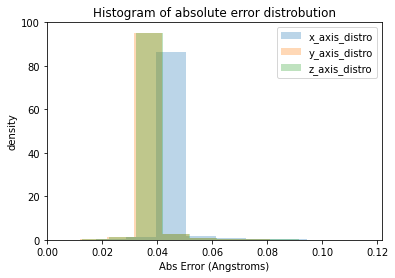

In [28]:
plt.title("Histogram of absolute error distrobution")
plt.hist( errors_3d[:, 0].numpy(), alpha=0.3, density=True, label="x_axis_distro")
plt.hist( errors_3d[:, 1].numpy(), alpha=0.3, density=True, label="y_axis_distro")
plt.hist( errors_3d[:, 2].numpy(), alpha=0.3, density=True, label="z_axis_distro")
plt.xlim(0,None)
plt.legend()
plt.ylabel("density")
plt.xlabel("Abs Error (Angstroms)")
plt.show()

### Make cool plot

In [29]:
joblib.dump({"rmsd": errors, "axis_abs": errors_3d}, "experiments/looping_error.joblib")
data = joblib.load("experiments/looping_error.joblib")

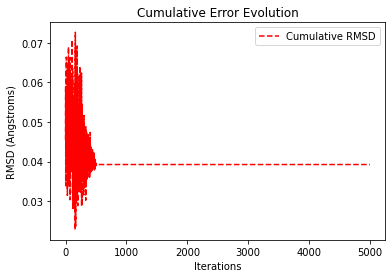

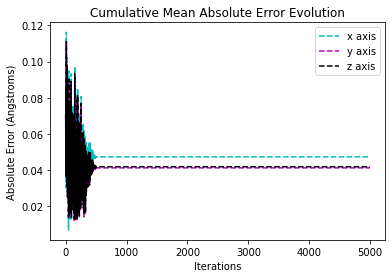

In [30]:
# RMSD
plt.title("Cumulative Error Evolution")
plt.plot(data["rmsd"], 'r--', label="Cumulative RMSD")
plt.ylabel("RMSD (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()

# 3d axis ABS ERROR
plt.title("Cumulative Mean Absolute Error Evolution")
plt.plot(data["axis_abs"][:, 0].numpy(), 'c--', label="x axis")
plt.plot(data["axis_abs"][:, 1].numpy(), 'm--', label="y axis")
plt.plot(data["axis_abs"][:, 2].numpy(), 'k--', label="z axis")
plt.ylabel("Absolute Error (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()

## Plot

In [31]:
coords_flat = rearrange(coords_wrapper, 'l c d -> (l c) d')

In [32]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [33]:
# base structure with current coords
sb = sidechainnet.StructureBuilder(int_seq, crd=true_coords) # coords_flat

# scn custom nerf
# sb = sidechainnet.StructureBuilder(int_seq[:-padding_angles], angles[:-padding_seq])

# put structure coords in wrapper
sb._initialize_coordinates_and_PdbCreator()
true_coords = sb.coords
# true_coords = rearrange(scn_struct_coords, '(l c) d -> l c d', c=14)

sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [34]:
# save predicted
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_pdb("preds/predicted.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=true_coords) 
sb.to_pdb("preds/labels.pdb")
# go here: https://molstar.org/viewer/
# load chains and use superimposition tool